<h1 style="color: #FECB05; text-align: center;">DBSCAN (Agrupamiento Espacial Basado en Densidad de Aplicaciones con Ruido)</h1>

<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png">

<figcaption>*Los ejemplos de los resultados de diferentes algoritmos de scikit-learn.*</figcaption></figure>

<h2 id="section1" style="color: #007ACC;">Introducción</h2>

Vamos a explorar una de las técnicas más interesantes en el mundo del aprendizaje no supervisado: el clustering. Como recordarán, el objetivo del clustering es agrupar datos que son similares entre sí sin tener etiquetas previas que nos guíen. Es como organizar una caja de legos por color y forma sin que nadie nos diga cómo hacerlo.

Probablemente ya conocen a uno de los algoritmos más famosos: K-Means. Es rápido, sencillo y funciona muy bien cuando nuestros datos forman grupos compactos y esféricos, como nubes de puntos bien definidas.

Pero, ¿qué pasa cuando la realidad es más compleja? ¿Qué hacemos si nuestros datos se distribuyen en formas extrañas, como dos lunas entrelazadas o anillos concéntricos?  Aquí es donde K-Means empieza a tener problemas, ya que su lógica de buscar centros de gravedad (centroides) no le permite capturar estas estructuras complejas. Además, K-Means es muy sensible a los outliers o "ruido", esos puntos raros y aislados que pueden desviar por completo la posición de nuestros clústeres.

Para resolver estos desafíos, necesitamos un enfoque diferente, uno que no piense en "centros", sino en "densidad".

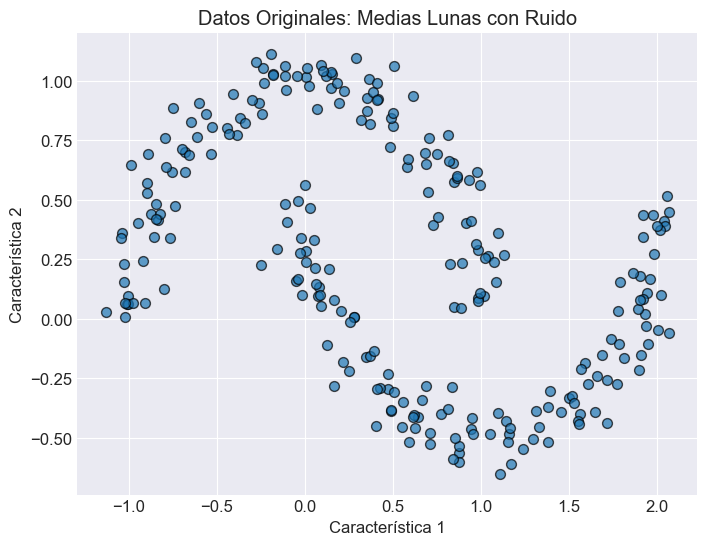

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans # Para comparación
from sklearn.preprocessing import StandardScaler # Para estandarizar los datos si fuera necesario

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-darkgrid')

X, y_true = make_moons(n_samples=250, noise=0.08, random_state=42)

# Visualizar los datos generados
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, edgecolors='k', alpha=0.7)
plt.title('Datos Originales: Medias Lunas con Ruido')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True)
plt.show()

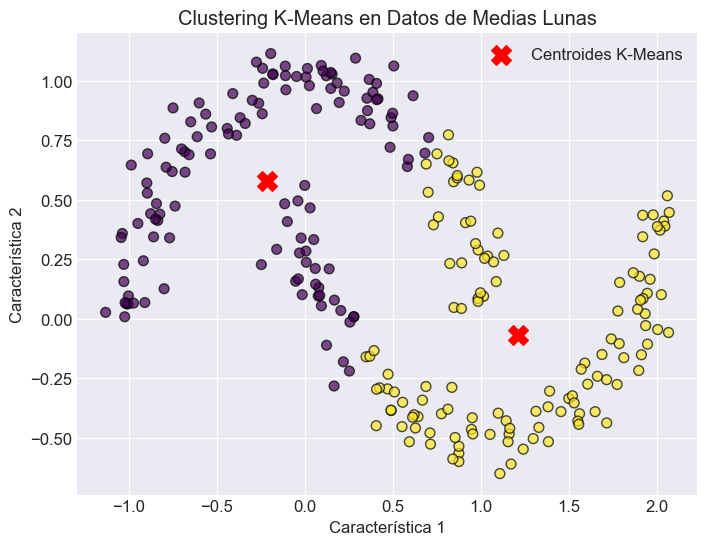

In [4]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

# Visualizar los resultados de K-Means
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, s=50, cmap='viridis', edgecolors='k', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, marker='X', c='red', label='Centroides K-Means')
plt.title('Clustering K-Means en Datos de Medias Lunas')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.grid(True)
plt.show()

Como puedes observar en el gráfico, K-Means no logra separar correctamente las dos medias lunas.

En lugar de identificar cada luna como un clúster, K-Means ha dividido las lunas de manera vertical, intentando formar clústeres más "esféricos" alrededor de sus centroides. ¡Ha fallado en capturar la verdadera estructura de los datos! Esto sucede porque K-Means se basa en la distancia al centroide y asume que los clústeres son convexos y de forma similar.

Aquí es donde entra en juego la potencia de los algoritmos basados en densidad. No se preocupan por "esferas" o "centros", sino por dónde los puntos están realmente apretados.

En esta clase, nos sumergiremos en el algoritmo más popular que utiliza esta filosofía: DBSCAN (Density-Based Spatial Clustering of Applications with Noise). Como su nombre indica, DBSCAN no solo es brillante para encontrar clústeres con formas arbitrarias, sino que también tiene la increíble capacidad de identificar y aislar los puntos que no pertenecen a ningún grupo, etiquetándolos como ruido.

<h2 id="section1" style="color: #007ACC;">La Matemática Detrás de DBSCAN</h2>

Aunque la idea intuitiva de "densidad" es fácil de entender, DBSCAN se basa en definiciones matemáticas precisas para funcionar de manera consistente. Formalizar estos conceptos nos permite ver exactamente cómo el algoritmo construye los clústeres.

Para empezar, necesitamos un conjunto de datos, que llamaremos $D$, y una función de distancia, `dist(p, q)`, que mida qué tan lejos están dos puntos $p$ y $q$ (comúnmente la distancia euclidiana).

<h3 style="color: #007ACC;"> Vecindad y Densidad </h3>

El primer concepto clave es la **$\epsilon$-vecindad** de un punto. Es simplemente el conjunto de todos los puntos que están a una distancia menor o igual que $\epsilon$ de un punto $p$.

**Definición Formal: $\epsilon$-vecindad**
La $\epsilon$-vecindad de un punto $p$, denotada como $N_{\epsilon}(p)$, se define como:
$$N_{\epsilon}(p) = \{q \in D \mid \text{dist}(p, q) \leq \epsilon\}$$



Con esta definición, podemos determinar si una región es "densa" y clasificar cada punto del dataset.

**Definición Formal: Puntos Núcleo, Frontera y Ruido**
Dados los hiperparámetros $\epsilon$ y `MinPts`:

1.  Un punto $p$ es un **punto núcleo (core point)** si su $\epsilon$-vecindad contiene al menos `MinPts` puntos. Matemáticamente:
    $$|N_{\epsilon}(p)| \geq \text{MinPts}$$
    Estos puntos son el corazón de un clúster.

2.  Un punto $q$ es un **punto frontera (border point)** si no es un punto núcleo, pero pertenece a la $\epsilon$-vecindad de algún punto núcleo $p$. Formalmente, $q$ es un punto frontera si:
    $$|N_{\epsilon}(q)| < \text{MinPts} \quad \text{y} \quad \exists p \in D : (|N_{\epsilon}(p)| \geq \text{MinPts} \land \text{dist}(p, q) \leq \epsilon)$$
    Estos puntos están en el borde del clúster, pero no son lo suficientemente densos para iniciar uno.

3.  Un punto $r$ es un **punto de ruido (noise point)** si no es ni un punto núcleo ni un punto frontera.

<h3 style="color: #007ACC;"> Construyendo los Clústeres: Alcanzabilidad y Conectividad </h3>

DBSCAN utiliza estas clasificaciones de puntos para definir cómo se expanden y forman los clústeres. Esto se hace a través de dos conceptos clave: alcanzabilidad y conectividad.

**Definición Formal: Alcanzabilidad por Densidad (Density-Reachability)**

* **Alcanzabilidad Directa:** Un punto $q$ es *directamente alcanzable por densidad* desde un punto núcleo $p$ si $q$ está dentro de la $\epsilon$-vecindad de $p$.
    $$q \in N_{\epsilon}(p) \quad \text{y} \quad |N_{\epsilon}(p)| \geq \text{MinPts}$$
    **(Importante:** Solo se puede ser directamente alcanzable desde un punto núcleo).

* **Alcanzabilidad (Indirecta):** Un punto $p_n$ es *alcanzable por densidad* desde un punto $p_1$ si existe una cadena de puntos $p_1, p_2, \dots, p_n$ donde cada $p_{i+1}$ es directamente alcanzable desde $p_i$.
    
    Esto es lo que permite que el clúster crezca y tome formas arbitrarias, como una cadena de perlas.

**Definición Formal: Conectividad por Densidad (Density-Connectedness)**

Dos puntos $p$ y $q$ están *conectados por densidad* si existe un punto núcleo $o$ tal que tanto $p$ como $q$ son alcanzables por densidad desde $o$.
Esta definición asegura que dos puntos frontera en extremos opuestos de un clúster se consideren parte del mismo grupo, siempre que estén conectados a través de una cadena de puntos núcleo.

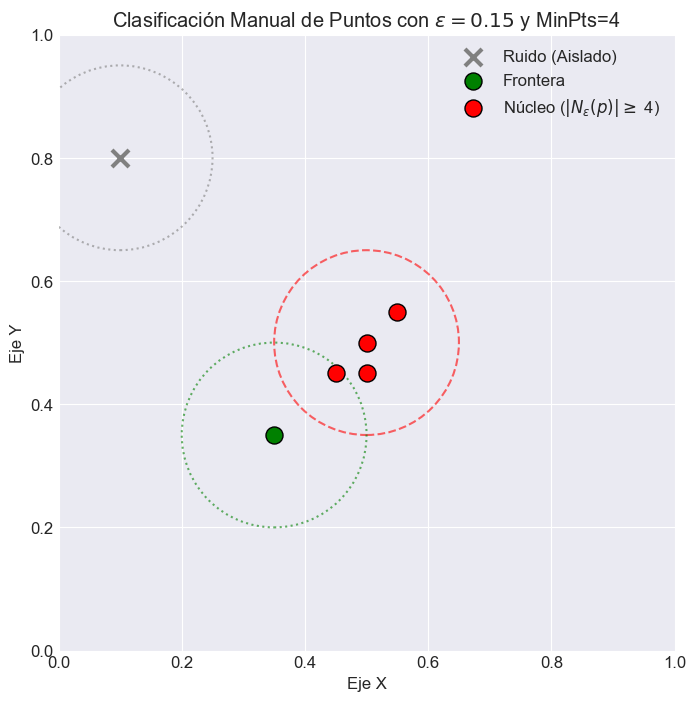

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# --- 1. Definir un conjunto de datos manualmente para un control total ---
# Clúster que formará los puntos núcleo
core_cluster = np.array([
    [0.5, 0.5], [0.55, 0.55], [0.45, 0.45], [0.5, 0.45]
])
# Un punto que estará cerca del clúster para ser frontera
border_point = np.array([[0.35, 0.35]])
# Un punto aislado que será ruido
noise_point = np.array([[0.1, 0.8]])

# Unimos todos los puntos en un solo array
X_example = np.vstack([core_cluster, border_point, noise_point])

# --- 2. Definir hiperparámetros ---
epsilon = 0.15 # Radio de vecindad
min_pts = 4    # Mínimo de puntos para ser considerado denso

# --- 3. Clasificar los puntos (mismo código de antes) ---
nbrs = NearestNeighbors(radius=epsilon).fit(X_example)
distances, indices = nbrs.radius_neighbors(X_example)

core_points_indices = []
border_points_indices = []
noise_points_indices = []
is_core = np.zeros(len(X_example), dtype=bool)

# Primera pasada: Identificar Puntos Núcleo
for i in range(len(X_example)):
    # len(indices[i]) incluye al punto mismo
    if len(indices[i]) >= min_pts:
        core_points_indices.append(i)
        is_core[i] = True

# Segunda pasada: Identificar Puntos Frontera y Ruido
for i in range(len(X_example)):
    if not is_core[i]:
        is_border = False
        # Revisar si es vecino de algún punto núcleo
        for core_idx in core_points_indices:
            if i in indices[core_idx]:
                is_border = True
                break
        
        if is_border:
            border_points_indices.append(i)
        else:
            noise_points_indices.append(i)

# --- 4. Visualizar los resultados ---
plt.figure(figsize=(10, 8))

# Puntos de Ruido
if noise_points_indices:
    plt.scatter(X_example[noise_points_indices, 0], X_example[noise_points_indices, 1], 
                s=150, color='gray', marker='x', label=f'Ruido (Aislado)', zorder=2, lw=3)

# Puntos Frontera
if border_points_indices:
    plt.scatter(X_example[border_points_indices, 0], X_example[border_points_indices, 1], 
                s=150, color='green', marker='o', edgecolors='k', label=f'Frontera', zorder=3)

# Puntos Núcleo
if core_points_indices:
    plt.scatter(X_example[core_points_indices, 0], X_example[core_points_indices, 1], 
                s=150, color='red', marker='o', edgecolors='k', label=f'Núcleo ($|N_\\epsilon(p)| \\geq$ {min_pts})', zorder=4)

# Dibujar el círculo de épsilon para el primer punto núcleo
sample_core_idx = core_points_indices[0]
circle_core = plt.Circle(X_example[sample_core_idx], epsilon, color='red', fill=False, linestyle='--', linewidth=1.5, alpha=0.6, zorder=1)
plt.gca().add_patch(circle_core)

# Dibujar el círculo de épsilon para el punto frontera
sample_border_idx = border_points_indices[0]
circle_border = plt.Circle(X_example[sample_border_idx], epsilon, color='green', fill=False, linestyle=':', linewidth=1.5, alpha=0.6, zorder=1)
plt.gca().add_patch(circle_border)

# Dibujar el círculo de épsilon para el punto de ruido
sample_noise_idx = noise_points_indices[0]
circle_noise = plt.Circle(X_example[sample_noise_idx], epsilon, color='gray', fill=False, linestyle=':', linewidth=1.5, alpha=0.6, zorder=1)
plt.gca().add_patch(circle_noise)

plt.title(f'Clasificación Manual de Puntos con $\\epsilon={epsilon}$ y MinPts={min_pts}')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

<h3 style="color: #007ACC;"> Definición Final de un Clúster </h3>

Con todo esto, ya podemos definir formalmente qué es un clúster para DBSCAN:

Un **clúster $C$** es un subconjunto no vacío de puntos de $D$ que cumple dos propiedades:
1.  **Maximality:** Si un punto $p$ está en el clúster $C$, y otro punto $q$ es alcanzable por densidad desde $p$, entonces $q$ también debe pertenecer a $C$.
2.  **Connectivity:** Todos los puntos dentro del clúster $C$ están mutuamente conectados por densidad.

Finalmente, el **ruido** se define como el conjunto de todos los puntos en $D$ que no pertenecen a ningún clúster.

<h3 style="color: #007ACC;"> Algoritmo de DBSCAN</h3>

Ya que entendemos los conceptos de punto núcleo, frontera y ruido, podemos ensamblar el rompecabezas y ver cómo el algoritmo DBSCAN los utiliza para descubrir clústeres. El proceso es sorprendentemente lógico y se puede describir como una "expansión basada en densidad".

La idea principal es simple: encontrar un punto núcleo y expandir un clúster a partir de él, absorbiendo todo lo que sea "alcanzable por densidad".

**El Proceso Paso a Paso**

El algoritmo recorre los puntos del conjunto de datos y sigue esta lógica:

1.  **Iniciar:** Elige un punto arbitrario que no haya sido visitado todavía.

2.  **Verificar Vecindad:** Revisa su $\\epsilon$-vecindad para contar cuántos vecinos tiene.

      * **Si es un Punto Núcleo** (tiene `MinPts` o más vecinos):
        a.  Se crea un **nuevo clúster** y se le asigna este punto.
        b.  Se examina a **cada vecino** dentro de su $\\epsilon$-vecindad. A cada uno de ellos se le añade a una lista de "semillas" o "pendientes" para ser procesado.
        c.  Mientras la lista de semillas no esté vacía, se toma un punto de ella:
        i.  Si el punto no ha sido visitado, se marca como visitado.
        ii. Si no pertenece a ningún clúster, se le añade al clúster actual.
        iii. Si este punto también es un **punto núcleo**, se añaden *todos sus vecinos* a la lista de semillas. Este es el paso clave de la **expansión**: un punto núcleo "contagia" a sus vecinos, y si uno de ellos también es núcleo, el contagio se propaga.
      * **Si NO es un Punto Núcleo** (tiene menos de `MinPts` vecinos):
        a.  Se etiqueta temporalmente como **Ruido**.
        b.  Es importante destacar que esta etiqueta puede cambiar. Si más adelante este punto es encontrado dentro de la $\\epsilon$-vecindad de un punto núcleo, será "rescatado" y se convertirá en un **punto frontera** de ese clúster.

3.  **Repetir:** El algoritmo continúa este proceso, saltando de un punto no visitado a otro, hasta que todos los puntos del dataset han sido visitados y asignados a un clúster o etiquetados definitivamente como ruido.

**Pseudocódigo del Algoritmo**

Para una visión más formal, el algoritmo se puede expresar con el siguiente pseudocódigo:

```
DBSCAN(D, eps, MinPts):
   C = 0  // Contador de clústeres
   para cada punto P en el dataset D:
      si P ya fue visitado, continuar al siguiente punto

      marcar P como visitado
      
      Vecinos = encontrar_vecinos(P, eps) // Encuentra puntos en la epsilon-vecindad de P
      
      si tamaño(Vecinos) < MinPts:
         marcar P como RUIDO
      sino:
         C = C + 1 // Nuevo clúster
         expandir_cluster(P, Vecinos, C, eps, MinPts)

expandir_cluster(P, Vecinos, C, eps, MinPts):
   asignar clúster C al punto P
   
   // Procesar todos los vecinos de P
   lista_semillas = Vecinos
   mientras lista_semillas no esté vacía:
      Punto_actual = tomar primer punto de lista_semillas
      
      si Punto_actual no fue visitado:
         marcar Punto_actual como visitado
         Nuevos_vecinos = encontrar_vecinos(Punto_actual, eps)
         
         // Si Punto_actual es un punto núcleo, expandir más
         si tamaño(Nuevos_vecinos) >= MinPts:
            añadir Nuevos_vecinos a lista_semillas
            
      // Si el punto aún no pertenece a ningún clúster, añadirlo al actual
      si Punto_actual no tiene asignado un clúster:
         asignar clúster C a Punto_actual
```

Este proceso de expansión es lo que permite a DBSCAN "conectar los puntos" para formar clústeres de cualquier forma, siempre que los puntos estén densamente conectados. Es como un incendio forestal: comienza en un punto denso (núcleo) y se propaga a través de la vegetación cercana (vecinos), continuando la expansión desde cualquier nuevo foco denso que encuentre en su camino.

<img src="https://cdn-images-1.medium.com/max/640/1*tc8UF-h0nQqUfLC8-0uInQ.gif" alt="1*tc8UF-h0nQqUfLC8-0uInQ.gif">

Fuente: [Density-Based Spatial Clustering of Applications with Noise (DBSCAN)](https://primo.ai/index.php/Density-Based_Spatial_Clustering_of_Applications_with_Noise_%28DBSCAN%29)

/var/folders/7v/mlpbd2vj15s13pz4rjm4bq1m0000gn/T/ipykernel_23262/3672247950.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


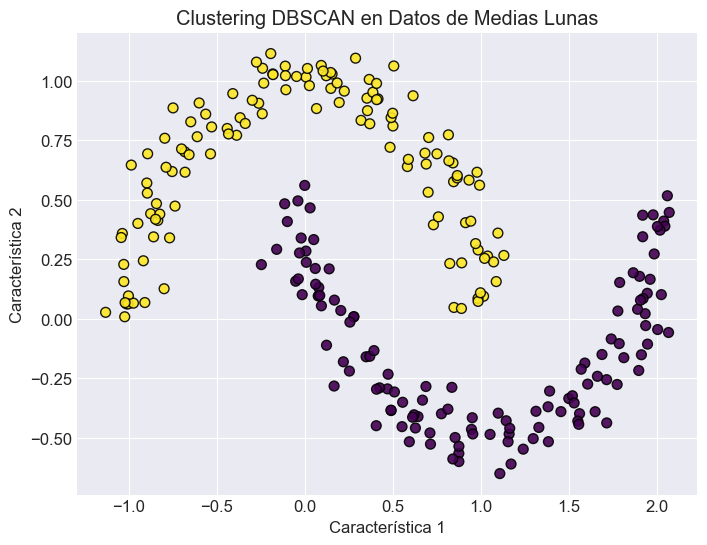

Número estimado de clústeres: 2
Número estimado de puntos de ruido: 0


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN, KMeans

# --- Código previo (Generación de datos) ---
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-darkgrid')

X, y_true = make_moons(n_samples=250, noise=0.08, random_state=42)

# --- Aplicación de DBSCAN ---
# Instanciamos DBSCAN. Los valores de eps y min_samples son cruciales.
# Un eps de 0.3 es suficientemente grande para conectar los puntos de cada luna,
# pero suficientemente pequeño para no unir ambas lunas.
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# --- Visualización de los Resultados de DBSCAN ---
plt.figure(figsize=(8, 6))

# Separar los puntos que pertenecen a un clúster del ruido
# La etiqueta -1 es asignada por DBSCAN a los puntos considerados ruido.
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Puntos que pertenecen a clústeres
plt.scatter(X[core_samples_mask, 0], X[core_samples_mask, 1], c=dbscan_labels[core_samples_mask], 
            s=50, cmap='viridis', edgecolors='k', alpha=0.9)

# Puntos de ruido
noise_mask = (dbscan_labels == -1)

plt.title('Clustering DBSCAN en Datos de Medias Lunas')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir el número de clústeres encontrados (excluyendo el ruido)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f'Número estimado de clústeres: {n_clusters}')
print(f'Número estimado de puntos de ruido: {n_noise}')

<h3 style="color: #007ACC;"> Tabla Comparativa: K-Means vs. DBSCAN </h3>

| Característica | K-Means | DBSCAN |
| :--- | :--- | :--- |
| **Principio Fundamental** 🧠 | **Basado en centroides**. Agrupa los datos asignándolos al centroide más cercano. | **Basado en densidad**. Conecta puntos que están muy juntos, separados por áreas de baja densidad. |
| **Forma de los Clústeres** | Asume clústeres de forma **esférica y convexa**. Falla con formas complejas. | Puede encontrar clústeres de **formas arbitrarias** (ej. lunas, anillos). |
| **Número de Clústeres (k)** | **Requiere** que el usuario especifique el número de clústeres (`k`) de antemano. | Determina el número de clústeres **automáticamente** según la densidad de los datos. |
| **Manejo de Ruido (Outliers)** | **Sensible a outliers**. Fuerza a cada punto a pertenecer a un clúster, lo que puede distorsionar los resultados. | **Robusto frente a outliers**. Los identifica y los etiqueta explícitamente como **ruido**. |
| **Hiperparámetros Clave** | Solo uno: el número de clústeres (`k`). | Dos: el radio de vecindad (`eps`) y los puntos mínimos (`min_samples`). Pueden ser menos intuitivos de ajustar. |
| **Densidad de los Clústeres** | No tiene problemas con clústeres de densidades diferentes, ya que no se basa en este concepto. | Tiene **dificultades** si los clústeres tienen densidades muy variables. |
| **Complejidad Computacional** | Generalmente **muy rápido** y escalable a grandes datasets. Complejidad casi lineal. | Puede ser más lento en datasets muy grandes, con una complejidad de O(n log n) o hasta O(n²) en el peor de los casos. |

**Cuándo Usar Cada Uno**

**Usa K-Means cuando:**
* Tienes una idea clara de **cuántos clústeres** (`k`) esperas encontrar.
* Sabes o supones que tus datos forman agrupaciones **compactas y esféricas**.
* La **velocidad** de ejecución y la simplicidad son tus prioridades principales.
* El conjunto de datos es muy grande y necesitas una solución escalable.

***Usa DBSCAN cuando:**
* **No sabes** el número de clústeres de antemano.
* Sospechas que los clústeres pueden tener **formas irregulares o complejas**.
* Crees que tu conjunto de datos contiene **ruido o valores atípicos** que necesitas identificar y separar.
* Los clústeres en tus datos tienen una densidad similar.